# Binary Classification with Principle Component Analysis

This notebook shows the implementation of Principle Component Analysis (PCA), a powerful linear dimensionality reduction technique which can be used to build a classifier with a reduced number of features and remove redundancy in the data.

### Data
We will be working with the MNIST dataset from (http://yann.lecun.com/exdb/mnist/).  
- MNIST contains size-normalized and centered 28x28 pixel images of handwritten digits.

### Classification Model
 - We will build a binary classifier on the selected two digits (labelp and labeln)
 - Classifier: Gaussian Naive Bayes (GaussianNB) from sklearn library

## Implementation
Let us import required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import pylab as plb
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

Load the training and test datasets and print out the size of loaded data

In [2]:
from misc.utils import load_mnist

labelp, labeln = 1,5
images, labels = load_mnist('training', digits = [labeln,labelp])
test_images, test_labels = load_mnist('testing', digits = [labeln,labelp])
print("Shape of images data:", images.shape) # must be [Number of training samples, 28,28]
print("Shape of labels data:",labels.shape) # [Number of training samples, ]
print("Shape of images data:", test_images.shape) # must be [Number of test samples, 28,28]
print("Shape of labels data:", test_labels.shape) # [Number of test sample, ]

Shape of images data: (12163, 28, 28)
Shape of labels data: (12163,)
Shape of images data: (2027, 28, 28)
Shape of labels data: (2027,)


Plot some random image from training set and show its label

Image Label: 1


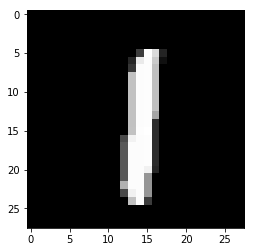

In [3]:
from random import randint
index_n = randint(0,images.shape[0])
image_array = images[index_n]
plt.imshow(image_array,cmap='gray',interpolation='None')
print("Image Label: " + str(int(labels[index_n])))

Now, we should do preprocessing to our data

In [4]:
X_train, y_train = np.asarray([i.ravel() for i in images]), np.asarray(labels)
X_test, y_test = np.asarray([i.ravel() for i in test_images]),np.asarray(test_labels)
print("Shape of flattened images:", X_train.shape) # must be [Number of training samples, 784]
print("Shape of labels data:", y_train.shape) # [Number of training samples, ]

Shape of flattened images: (12163, 784)
Shape of labels data: (12163,)


We ready to start PCA. Let's get started
### PCA
Firstly, we should compute covariance matrix $\Sigma$ of the training set $X$. 
\begin{align}
\Sigma & = \frac{1}{(n-1)}((X-\bar{x})^T(X-\bar{x})) \\
\end{align}
where, $x$ is the mean vector of each feature in $X$ and $n$ is number of training samples


In [5]:
mu = np.mean(X_train, axis=0)
cov_mat = (X_train - mu).T.dot((X_train - mu)) / (X_train.shape[0]-1)
cov_mat.shape

(784, 784)

Or, we can use covariance matrix calculation from numpy and as a sanity check, compare two computed matrices

True

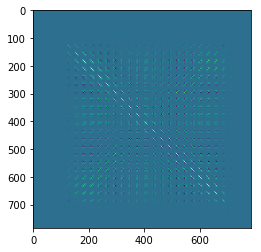

In [6]:
cov_np = np.cov(X_train,rowvar=False)
plt.imshow(cov_np)
np.allclose(cov_np,cov_mat)

Next, let us compute eigenvalues and eigenvectors of the covariance matrix

In [7]:
eigval, eigvector = np.linalg.eig(cov_np)

eigval[:10], eigvector.shape

(array([ 499514.00743205+0.j,  294332.35643075+0.j,  198090.92130444+0.j,
         134302.06452584+0.j,  104510.53865527+0.j,   91547.79163723+0.j,
          77116.53273690+0.j,   59791.89167064+0.j,   51301.22185928+0.j,
          45563.11192050+0.j]), (784, 784))

Finally, we can get projection of our data into subspace with reduced dimensions

\begin{align}
P = X \cdot W
\end{align}
where $W$ is $d \times n$ matrix with projection into $n$-dimensional subspace, in other words, first $n$ eigenvectors.  
For 2D visualization, let us pick only 2-components

In [8]:
W = np.real(eigvector[:,:2])
print ("Size of W:", W.shape)
P_train=np.dot(X_train-mu,W);
P_train.shape

Size of W: (784, 2)


(12163, 2)

### Visualization of 2D subspace

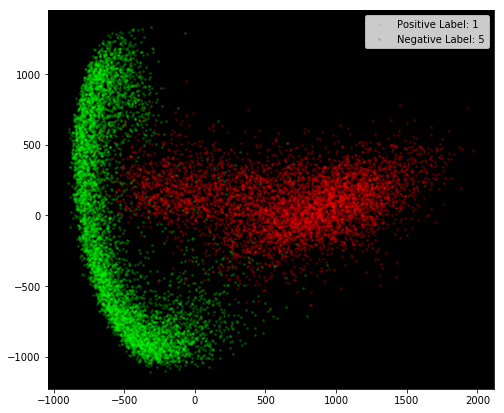

In [9]:
from misc.utils import binary_plot
# Separate into two arrays 
x1, x2 = binary_plot(P_train,y_train,labelp)


# Plot
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111,facecolor='black')
ax.scatter(x1[:,0],x1[:,1],s=7,linewidths=0,facecolors=[0,1,0,0.3],marker="o") # Green color for Positive
ax.scatter(x2[:,0],x2[:,1],s=7,linewidths=0,facecolors=[1,0,0,0.3],marker="o") # Red color for Negative
ax.legend(['Positive Label: '+str(labelp),'Negative Label: '+str(labeln)])
ax.set_aspect('equal')

### Training model
Now, we are training our Naive Bayes Classifier with 2d projected training dataset

In [10]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
_ = clf.fit(P_train, y_train)

### Testing Model
Next, project test data into 2D subspace and test our trained model

In [11]:
### Project our test data into 2D subspace
P_test = np.dot(X_test-mu,W);

### Predict
y_predict = clf.predict(P_test)

### Results

In [12]:
from sklearn.metrics import accuracy_score
print ("%.2f%% accuracy"%(accuracy_score(y_test, y_predict)*100))

96.05% accuracy


Wow, it seems excellent result! However, note that we use only two labels for our classification purpose

## Or, super-fast way to implement all the steps  
sklearn package of course))

In [13]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Initialize pipeline with PCA transformation and selecting GaussianNB as an estimator
pca_clf = Pipeline([('pca', PCA()),('classifier', GaussianNB())])
# Set parameters
pca_clf.set_params(pca__n_components=2).fit(X_train, y_train)
y_pip_predict = pca_clf.predict(X_test)
# Print accuracy
print ("%.2f%% accuracy"%(accuracy_score(y_test, y_pip_predict)*100))

96.05% accuracy


### Confusion matrix
Let us draw confusion matrix and infer some useful statistics

True Positive 1127
True Negative 820
False Positive 72
False Negative 8


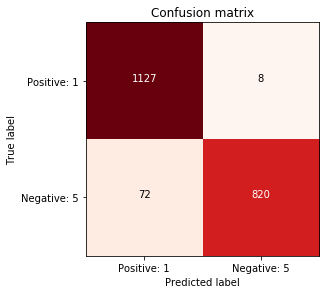

In [14]:
from misc.utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test,y_predict)
plot_confusion_matrix(cnf_matrix, labels=["Positive: "+str(labelp),"Negative: "+str(labeln)])
tp, fn, fp, tn = cnf_matrix.ravel()
print ("True Positive %d"%tp)
print ("True Negative %d"%tn)
print ("False Positive %d"%fp)
print ("False Negative %d"%fn)

### Extra: Sanity Checks

Here, we would like to check if our PCA and sklearn PCA components are same

In [15]:
# initiate PCA and classifier from sklearn
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X_train)
X_transformed.shape, P_train.shape

((12163, 2), (12163, 2))

In [16]:
# sanity check
np.allclose(X_transformed,P_train)

False

Oops, it seems like they are not the same. Let us look closely then

In [17]:
X_transformed[:2],P_train[:2]

(array([[  768.4316177 ,    12.32914365],
        [ -666.51619735,  1024.84516889]]),
 array([[  768.43161945,    12.329037  ],
        [ -666.51619863,  1024.84517544]]))

We can notice that the error is in some decimal places, it might be because we implement the different approach to find eigenvectors. Thus, we should set some error tolerance when we use $numpy.allclose()$ function

In [18]:
np.allclose(X_transformed,P_train,atol=1e-3)

True

In [19]:
# Sanity check for eigenvectors
np.allclose(pca.components_,W.T)

True

Now, let us reconstruct our image from PCA

In [20]:
rec_train = P_train.dot(W.T)+mu

Label: 1


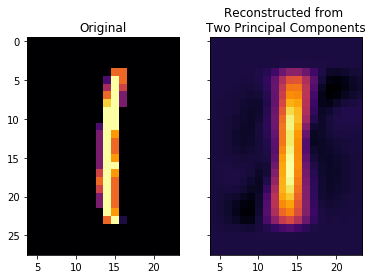

In [21]:
np.random.seed(4)
idx = np.random.randint(0,len(y_train))

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(images[idx],interpolation='None', cmap=plb.cm.inferno)
ax1.set_title('Original')
ax2.imshow(rec_train[idx].reshape(28, 28),interpolation='None', cmap=plb.cm.inferno)
ax2.set_title('Reconstructed from \nTwo Principal Components')
print ('Label: '+str(labels[idx]))

### Wrap-up
We implemented PCA to reduce feature dimensions. For illustration purpose, we used only 2-components. However, there is a systematic approach to pick the right number of components to represent the data. We will conclude our notebook with the illustration of "explained variance" (https://en.wikipedia.org/wiki/Explained_variation)

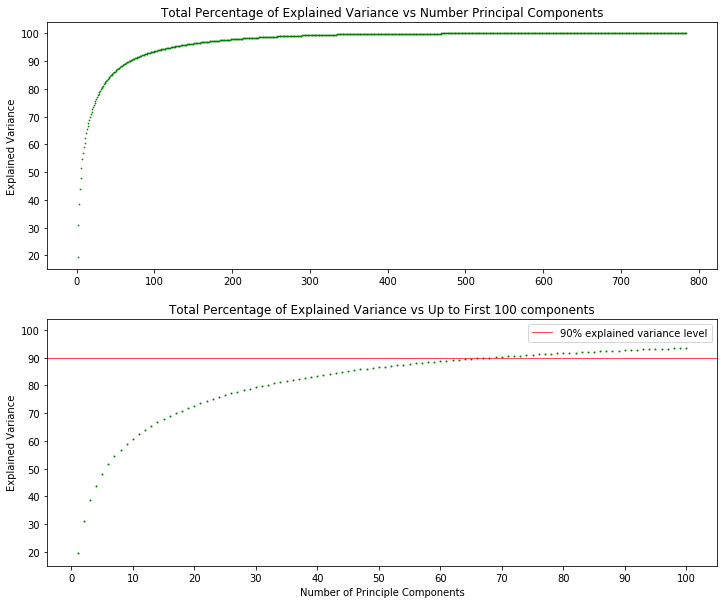

In [22]:
from misc.utils import variance_plot

var_exp = np.cumsum(np.real(eigval)*100/sum(np.real(eigval)))
num_comp = np.arange(1,len(var_exp)+1)
variance_plot(num_comp,var_exp)

For our particular example, it seems reasonable to select 70 components to represent the data.